In [1]:
from google.colab import files, drive
drive.mount('/content/drive')
! ln -s drive/MyDrive/CV-Project/dataset ./dataset
# ! pip install -U -q opencv-python
! pip install opencv-contrib-python==4.4.0.44
! pip install -q open3d
! pip install -q pykitti
! pip install -q plotly
# ! pip install -q evo
! pip install evo --upgrade --no-binary evo


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link './dataset/dataset': File exists
Requirement already up-to-date: evo in /usr/local/lib/python3.7/dist-packages (1.13.5)


In [2]:
def preprocess_point_cloud(pcd, voxel_size):
    # print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    # print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    # print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def prepare_dataset(voxel_size, source, target):
    # print(":: Load two point clouds and disturb initial pose.")
    # source = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
    # target = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_1.pcd")
    # trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
    #                          [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    # source.transform(trans_init)
    # draw_registration_result(source, target, np.identity(4))
    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    # print(":: RANSAC registration on downsampled point clouds.")
    # print("   Since the downsampling voxel size is %.3f," % voxel_size)
    # print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(10000000, 0.999))
    return result

In [3]:
import pykitti
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from typing import *
from time import time
import cv2
import open3d as o3d
import copy


windowSize = 5

stereoParams = {
    'minDisparity': 16,
    'numDisparities': 100,
    'blockSize': 15,
    'P1': 8*3*windowSize**2,
    'P2': 32*3*windowSize**2,
    'disp12MaxDiff': 1,
    'uniquenessRatio': 10
}

def writeKitti(poses: List[np.ndarray], filename='stereoVO.txt'):
    with open(filename, 'w') as f:
        for p in poses:
            f.write(f"{' '.join(map(str, p[:3].reshape(-1)))}\n")

def getSIFT(im0: np.ndarray, im1: np.ndarray, nfeatures=None):
    if nfeatures is not None:
        detector = cv2.SIFT_create(nfeatures=nfeatures)
    else:
        detector = cv2.SIFT_create()
    detector = cv2.SIFT_create(nfeatures=nfeatures)
    kp0, des0 = detector.detectAndCompute(im0, None)
    kp1, des1 = detector.detectAndCompute(im1, None)
    return kp0, des0, kp1, des1

def matchFeature(kp0, des0: np.ndarray, kp1, des1: np.ndarray, coeff=0.8, distMeasure=cv2.NORM_L2):
    bf = cv2.BFMatcher(distMeasure)
    pts0 = []
    pts1 = []
    match = []
    for m, n in bf.knnMatch(des0, des1, k=2):
        if m.distance < coeff*n.distance:
            pts0.append(kp0[m.queryIdx].pt)
            pts1.append(kp1[m.trainIdx].pt)
            match.append(1)
        else:
            match.append(0)
    return np.array(pts0), np.array(pts1), np.array(match)

def getStereoPtCloud(im0: np.ndarray, im1: np.ndarray, f: 'focal', b: 'baseline', downsample = True):
    h, w = im0.shape[:2]

    stereo = cv2.StereoSGBM_create(**stereoParams)
    disp = stereo.compute(im0, im1).astype(np.float32) / 16.0

    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0, 1, 0, -0.5*h],
                    [0, 0, 0,     -f],
                    [0, 0, -1/b,   0]])
    points = cv2.reprojectImageTo3D(disp, Q)
    points = points[disp > disp.min()]

    if downsample == True:
      points = points[np.random.randint(0, len(points), size = (50000))]

    return points

def preprocess_point_cloud(pcd, voxel_size):
    # print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    # print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    # print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def prepare_dataset(voxel_size, source, target):
    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    # print(":: RANSAC registration on downsampled point clouds.")
    # print("   Since the downsampling voxel size is %.3f," % voxel_size)
    # print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(10000000, 0.999))
    return result

def main():
    dataset = pykitti.odometry('./dataset', '00')
    print('calib cam0 intrinsic calibration\n', dataset.calib.K_cam0, '\n')
    print('calib cam1 intrinsic calibration\n', dataset.calib.K_cam1, '\n')
    print('calib baseline (meters)\n', dataset.calib.b_gray, '\n')
    print('calib cam0 projection\n', dataset.calib.P_rect_00, '\n')
    print('calib cam1 projection\n', dataset.calib.P_rect_10, '\n')

    print('\n Beginning VO...')
    currPose = np.hstack((np.eye(3), np.zeros((3, 1))))
    # currPose = np.eye(4)
    grImg = iter(dataset.gray)
    K = dataset.calib.K_cam0
    f = K[0, 0]
    baseline = dataset.calib.b_gray
    P0, P1 = dataset.calib.P_rect_00, dataset.calib.P_rect_10

    sTime = time()
    imA0, imA1 = map(np.array, next(grImg))
    ptCloudA = getStereoPtCloud(imA0, imA1, f, baseline)

    path = [currPose]
    ct = 0
    while True:
        ct += 1
        print(f'Path Points: {len(path):>4,}; Loop Time: {time() - sTime}')

        imB0, imB1 = imA0, imA1
        ptCloudB = ptCloudA

        sTime = time()
        try:
            imA0, imA1 = map(np.array, next(grImg))
            ptCloudA = getStereoPtCloud(imA0, imA1, f, baseline)
        except StopIteration:
            break

        src = o3d.geometry.PointCloud()
        src.points = o3d.utility.Vector3dVector(ptCloudA)

        tar = o3d.geometry.PointCloud()
        tar.points = o3d.utility.Vector3dVector(ptCloudB)

        voxel_size = 0.2  # means 5cm for this dataset
        source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, src, tar)

        result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
        # print(result_ransac)
        print(result_ransac.transformation)
        trans_init = result_ransac.transformation

        threshold = 0.1
        # print("Initial alignment")
        evaluation = o3d.pipelines.registration.evaluate_registration(src, tar,
                                                              threshold, trans_init)
        # print(evaluation)


        # print('ICP Alignment')
        reg_p2p = o3d.pipelines.registration.registration_icp(
            src, tar, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint())
        
        print(reg_p2p)
        # print(reg_p2p.transformation)

        currPose = currPose @ (reg_p2p.transformation)
        print(currPose)
        copyCurrPose = copy.deepcopy(currPose)
        copyCurrPose[0,-1] = -1*copyCurrPose[0,-1]
        copyCurrPose[1,-1] = -1*copyCurrPose[1,-1]
        path.append(copyCurrPose)

        xC = currPose[0,-1]
        zC = currPose[2,-1]

        plt.scatter(-xC, zC)

        # Early exit after 100 frames to demonstrate for submission:
        if ct == 100:
          break
          plt.show()

    writeKitti(path, 'drive/MyDrive/CV-Project/misc/stereoVO_50k.txt')

calib cam0 intrinsic calibration
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

calib cam1 intrinsic calibration
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

calib baseline (meters)
 0.5371657081270053 

calib cam0 projection
 [[718.856    0.     607.1928   0.    ]
 [  0.     718.856  185.2157   0.    ]
 [  0.       0.       1.       0.    ]] 

calib cam1 projection
 [[ 718.856     0.      607.1928 -386.1448]
 [   0.      718.856   185.2157    0.    ]
 [   0.        0.        1.        0.    ]] 


 Beginning VO...
Path Points:    1; Loop Time: 0.5232069492340088
[[ 0.99990801 -0.00928087  0.00989105 -0.10327782]
 [ 0.0091595   0.99988306  0.01224607 -0.04494353]
 [-0.01000354 -0.01215434  0.99987609  0.66092703]
 [ 0.          0.          0.          1.        ]]
RegistrationResult with fitness=5.043000e-01, inlier_rmse=5.612388e-02, and correspondence_set size of 25215
Access transformation

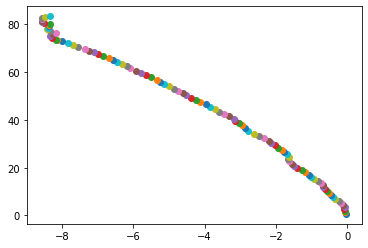

In [4]:
main()